# Finetune `wav2vec2` for Thai

This notebook is adapted from [Fine-tuning Wav2Vec2 for English ASR](https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_tuning_Wav2Vec2_for_English_ASR.ipynb) to train Thai ASR using [Common Voice Corpus 7.0](https://commonvoice.mozilla.org/en/datasets).

## What is `wav2vec2`

Wav2Vec2 is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by Alexei Baevski, Michael Auli, and Alex Conneau.

Using a novel contrastive pretraining objective, Wav2Vec2 learns powerful speech representations from more than 50.000 hours of unlabeled speech. Similar, to [BERT's masked language modeling](http://jalammar.github.io/illustrated-bert/), the model learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/wav2vec2.png)

For the first time, it has been shown that pretraining, followed by fine-tuning on very little labeled speech data achieves competitive results to state-of-the-art ASR systems. Using as little as 10 minutes of labeled data, Wav2Vec2 yields a word error rate (WER) of less than 5% on the clean test set of [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) - *cf.* with Table 9 of the [paper](https://arxiv.org/pdf/2006.11477.pdf).

## Installs and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.rpm.sh | sudo bash
# !sudo yum install git-lfs -y
# !git lfs install

In [ ]:
!unzip /content/drive/MyDrive/dataset.zip -d /content/drive/MyDrive/package
# !unzip /content/drive/MyDrive/onlyMP3.zip -d /content/drive/MyDrive/audio_file

Archive:  /content/drive/MyDrive/dataset.zip
  inflating: /content/drive/MyDrive/package/test.tsv  
  inflating: /content/drive/MyDrive/package/train.tsv  
  inflating: /content/drive/MyDrive/package/valid.tsv  


In [8]:

%%capture
!apt-get update
!apt-get install --reinstall build-essential --yes

In [9]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [6]:
%%capture
%pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
%pip install datasets==1.11.0
%pip install transformers==4.9.1
%pip install jiwer
%pip install ipywidgets
%pip install pythainlp==2.3.1

In [1]:
from functools import partial
import pandas as pd
import numpy as np
from datasets import (
    load_dataset, 
    load_from_disk,
    load_metric,)
from transformers import (
    Wav2Vec2CTCTokenizer, 
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor,
    
    Wav2Vec2ForCTC,
    TrainingArguments,
    Trainer,
)
import torchaudio
import re
import json
from pythainlp.tokenize import word_tokenize, syllable_tokenize

### Load Dataset

In [2]:
datasets = load_dataset("/content/drive/MyDrive/load_dataset.py", "th")
datasets

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset common_voice downloaded and prepared to /root/.cache/huggingface/datasets/common_voice/th/7.0.0/1b2d40cf5ad2e74fa7a31a8eaa9ffbfc79e7c9c3b8cd038daec3b16ade201151. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['path', 'sentence'],
        num_rows: 1307
    })
    test: Dataset({
        features: ['path', 'sentence'],
        num_rows: 436
    })
    validation: Dataset({
        features: ['path', 'sentence'],
        num_rows: 436
    })
})

In [7]:
def preprocess_data(example, tok_func = word_tokenize):
    example['sentence'] = ' '.join(tok_func(example['sentence']))
    return example

datasets = datasets.map(preprocess_data)

Parameter 'function'=<function preprocess_data at 0x7f74978d1c20> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1307 [00:00<?, ?ex/s]

  0%|          | 0/436 [00:00<?, ?ex/s]

  0%|          | 0/436 [00:00<?, ?ex/s]

### Exploration

In [8]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))
    
show_random_elements(datasets["train"].remove_columns(["path"]), num_examples=20)

,sentence
0,ลบ มัน ไป ทุก ข้อ
1,ตก จาก ฟากฟ้า
2,เล่า ให้ ฟัง ด้วย ความหวังดี
3,ช่วย บอก ให้ ฉัน ได้ รู้ ให้ มั่นใจ
4,หรือ ต้อง ให้ ฉัน แค่ แอบ มี เธอ ใน ใจ
5,เจอ คำ ว่า รัก คำ เดียว ก็ พัง ทำ อะไร ไม่ ได้
6,ที่ เธอ จะ ทิ้ง กัน ไป เพราะ เหตุ นั้น
7,นี้ อีก ยาว
8,ชัดเจน ว่า ทุกสิ่ง
9,ฉัน จะ เยียวยา ให้ หาย


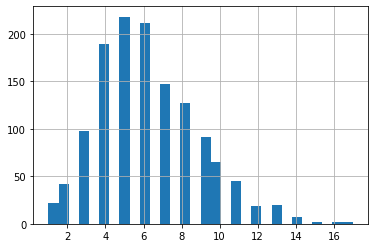

In [9]:
train_df = pd.DataFrame({'sentence':datasets['train']['sentence']})
train_df['nb_words'] = train_df.sentence.map(lambda x: len(x.split()))
train_df.nb_words.hist(bins=30)

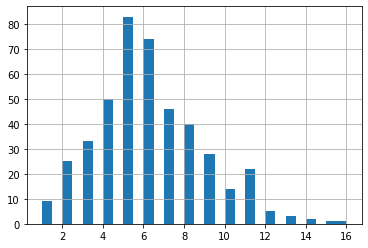

In [10]:
validation_df = pd.DataFrame({'sentence':datasets['validation']['sentence']})
validation_df['nb_words'] = validation_df.sentence.map(lambda x: len(x.split()))
validation_df.nb_words.hist(bins=30)

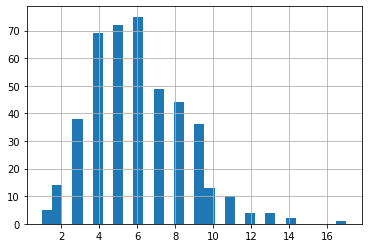

In [11]:
test_df = pd.DataFrame({'sentence':datasets['test']['sentence']})
test_df['nb_words'] = test_df.sentence.map(lambda x: len(x.split()))
test_df.nb_words.hist(bins=30)

In [12]:
from glob import glob

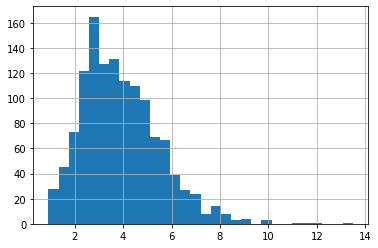

In [13]:
fname = glob('/content/drive/MyDrive/new_dataset/ready2train/*.mp3')
random.shuffle(fname)

data_path = list(datasets['train']['path'])
n_dpath =[]
for i in data_path:
  if i in fname:
    n_dpath.append(i)

train_df = pd.DataFrame({'path':n_dpath })
# train_df
# datasets['train']['path']

train_df['sample_rate'] = train_df.path.map(lambda x: torchaudio.info(x).sample_rate)
train_df['num_frames'] = train_df.path.map(lambda x: torchaudio.info(x).num_frames)
train_df['seconds'] = train_df.num_frames / train_df.sample_rate
train_df.seconds.hist(bins=30)

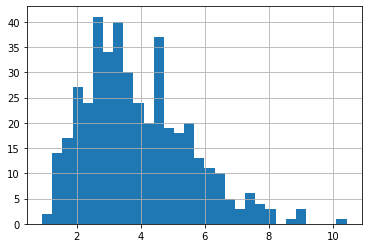

In [14]:
data_path = list(datasets['validation']['path'])
n_dpath =[]
for i in data_path:
  if i in fname:
    n_dpath.append(i)

validation_df = pd.DataFrame({'path':n_dpath })
# validation_df = pd.DataFrame({'path':datasets['validation']['path']})
validation_df['sample_rate'] = validation_df.path.map(lambda x: torchaudio.info(x).sample_rate)
validation_df['num_frames'] = validation_df.path.map(lambda x: torchaudio.info(x).num_frames)
validation_df['seconds'] = validation_df.num_frames / validation_df.sample_rate
validation_df.seconds.hist(bins=30)

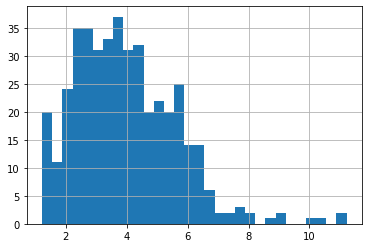

In [15]:
data_path = list(datasets['test']['path'])
n_dpath =[]
for i in data_path:
  if i in fname:
    n_dpath.append(i)

test_df = pd.DataFrame({'path':n_dpath })
test_df['sample_rate'] = test_df.path.map(lambda x: torchaudio.info(x).sample_rate)
test_df['num_frames'] = test_df.path.map(lambda x: torchaudio.info(x).num_frames)
test_df['seconds'] = test_df.num_frames / test_df.sample_rate
test_df.seconds.hist(bins=30)

In [ ]:
def extract_all_chars(batch, text_col = "sentence"):
    all_text = " ".join(batch[text_col])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = datasets.map(extract_all_chars, 
                   batched=True, 
                   batch_size=-1, 
                   keep_in_memory=True, 
                   remove_columns=datasets.column_names["train"])

vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["validation"]["vocab"][0]) |set(vocabs["test"]["vocab"][0]))
# vocab_list = list(set(vocabs["train"]["vocab"][0])) #strictly no leakage
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
len(vocab_dict), vocab_dict

In [17]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
#padding token serves as blank token
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict), vocab_dict

In [19]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("airesearch/wav2vec2-large-xlsr-53-th")

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
datasets['train'][0]['sentence']

'ฉัน มา บอ กว่า ฉัน เอง'

In [21]:
tokenizer(datasets['train'][0]['sentence'])

{'input_ids': [53, 45, 62, 42, 51, 16, 42, 33, 19, 42, 2, 47, 15, 16, 42, 53, 45, 62, 42, 28, 19, 3], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [22]:
tokenizer.decode(tokenizer(datasets['train'][0]['sentence']).input_ids)

'ฉัน มา บอ กว่า ฉัน เอง'

In [23]:
tokenizer.vocab_size

70

In [24]:
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, 
                                             sampling_rate=16000, 
                                             padding_value=0.0, 
                                             do_normalize=True, 
                                             return_attention_mask=False)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [25]:
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [26]:
def speech_file_to_array_fn(batch, 
                            text_col="sentence", 
                            fname_col="path",
                            resampling_to=16000):
    speech_array, sampling_rate = torchaudio.load(batch[fname_col])
    resampler=torchaudio.transforms.Resample(sampling_rate, resampling_to)
    batch["speech"] = resampler(speech_array)[0].numpy()
    batch["sampling_rate"] = resampling_to
    batch["target_text"] = batch[text_col]
    return batch

In [27]:
from glob import glob
import random

fname = glob('/content/drive/MyDrive/new_dataset/ready2train/*.mp3')
random.shuffle(fname)
datasets = datasets.filter(lambda example: example['path'] in fname)
speech_datasets = datasets.map(speech_file_to_array_fn, 
                                   remove_columns = datasets.column_names["train"])
speech_datasets

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1284 [00:00<?, ?ex/s]

  0%|          | 0/426 [00:00<?, ?ex/s]

  0%|          | 0/427 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['speech', 'sampling_rate', 'target_text'],
        num_rows: 1284
    })
    test: Dataset({
        features: ['speech', 'sampling_rate', 'target_text'],
        num_rows: 426
    })
    validation: Dataset({
        features: ['speech', 'sampling_rate', 'target_text'],
        num_rows: 427
    })
})

In [28]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(speech_datasets["train"]))
print(speech_datasets["train"][rand_int]["target_text"])
ipd.Audio(data=np.asarray(speech_datasets["train"][rand_int]["speech"]), autoplay=True, rate=16000)

ได้ โปรด อย่า มอง ตา


In [29]:
def prepare_dataset(batch):
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    batch["input_values"] = processor(batch["speech"], sampling_rate=batch["sampling_rate"][0]).input_values
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

In [30]:
prepared_datasets = speech_datasets.map(prepare_dataset, 
                                        remove_columns=speech_datasets.column_names["train"], 
                                        batch_size=16,
                                        batched=True)

  0%|          | 0/81 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)


  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

In [31]:
prepared_datasets

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 1284
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 426
    })
    validation: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 427
    })
})

In [32]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [33]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)


**metric**

In [34]:
wer_metric = load_metric("wer")

Downloading:   0%|          | 0.00/1.95k [00:00<?, ?B/s]

In [35]:
def compute_metrics(pred, processor, metric):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

**model**

In [36]:
model = Wav2Vec2ForCTC.from_pretrained(
    "airesearch/wav2vec2-large-xlsr-53-th",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

Downloading:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

In [37]:
model.freeze_feature_extractor()

In [38]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/new_dataset/wav2vec2-large-xlsr-53-thai-finetune",
    group_by_length=True,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    # auto_find_batch_size = True,
    per_device_eval_batch_size=16,
    metric_for_best_model='wer',
    evaluation_strategy="steps",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="steps",
    save_steps=500,
    num_train_epochs=100,
    # fp16=True,
    learning_rate=1e-4,
    warmup_steps=50,
    save_total_limit=3,
    report_to="tensorboard"
)

In [ ]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=partial(compute_metrics, metric=wer_metric, processor=processor),
    train_dataset=prepared_datasets["train"],
    eval_dataset=prepared_datasets["validation"],
    tokenizer=processor.feature_extractor,
)

In [ ]:
trainer.train()